In [7]:
import cv2
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

In [8]:
def hist(img, drop = None):
    img_ravel = img.ravel()
    if drop != None:
        img_ravel = img_ravel[img_ravel!=drop]
    plt.hist(img_ravel, bins=100)
    plt.show()
    
def enhance(img, brightness, contrast):
    IINFO = np.iinfo(img.dtype)

    if brightness != 0:
        brightness = np.floor((IINFO.max-IINFO.min)*brightness)

        alpha = (IINFO.max - np.abs(brightness)) / IINFO.max
        gamma = np.max(brightness, 0)

        img = img.copy()*alpha + gamma
        img[img>255] = 255
        img[img<0] = 0
        img = img.astype(IINFO.dtype)

    if contrast != 0:
        contrast = np.floor((IINFO.max-IINFO.min)*contrast)

        HALF = np.floor((IINFO.max+IINFO.min)/2)
        HALF_1 = HALF + 1

        f = HALF_1*(contrast+HALF)/(HALF_1-contrast)
        alpha = f/HALF
        gamma = HALF - f

        img = img.copy()*alpha + gamma
        img[img>255] = 255
        img[img<0] = 0
        img = img.astype(IINFO.dtype)
    
    return img
    
def plot(img, resize=1):
    img = cv2.resize(img, None, fx = resize, fy=resize)
    cv2.imshow('Input', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
def plus(a, b):
    
    assert a.dtype == b.dtype, "a & b have different types"
    
    MAX = np.iinfo(a.dtype).max
    
    b = MAX - b  # old b is gone shortly after new array is created
    np.putmask(a, b < a, b)  # a temp bool array here, then it's gone
    a += MAX - b  # a temp array here, then it's gone
    
    return a

def minus(a, b):
    
    assert a.dtype == b.dtype, "a & b have different types"
    
    min = np.iinfo(a.dtype).min
    
    b = b + MIN  # old b is gone shortly after new array is created
    np.putmask(a, a < b, b)  # a temp bool array here, then it's gone
    a -= b - MIN  # a temp array here, then it's gone
    
    return a
    
def hist_match(source, template, dtype=None):
    """
    Adjust the pixel values of a grayscale image such that its histogram
    matches that of a target image

    Arguments:
    -----------
        source: np.ndarray
            Image to transform; the histogram is computed over the flattened
            array
        template: np.ndarray
            Template image; can have different dimensions to source
    Returns:
    -----------
        matched: np.ndarray
            The transformed output image
    """

    oldshape = source.shape
    source = source.ravel()
    template = template.ravel()

    # get the set of unique pixel values and their corresponding indices and
    # counts
    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True, return_counts=True)
    t_values, t_counts = np.unique(template, return_counts=True)

    # take the cumsum of the counts and normalize by the number of pixels to
    # get the empirical cumulative distribution functions for the source and
    # template images (maps pixel value --> quantile)
    s_quantiles = np.cumsum(s_counts)
    s_quantiles = s_quantiles / s_quantiles[-1]
    t_quantiles = np.cumsum(t_counts)
    t_quantiles = t_quantiles / t_quantiles[-1]

    # interpolate linearly to find the pixel values in the template image
    # that correspond most closely to the quantiles in the source image
    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)
    interp_t_values_reshaped =  interp_t_values[bin_idx].reshape(oldshape)
    
    # Type conversion
    if dtype:
        interp_t_values_reshaped = interp_t_values_reshaped.astype(dtype)

    return interp_t_values_reshaped

In [9]:
Bs = glob("Landsat/*.tif")

# for i in range(len(Bs)):
#     print(i, Bs[i], cv2.imread(Bs[i], -1).shape)

In [10]:
B = cv2.resize(cv2.imread(Bs[3], 0), None, fx=2, fy=2, interpolation=cv2.INTER_NEAREST)
G = cv2.resize(cv2.imread(Bs[4], 0), None, fx=2, fy=2, interpolation=cv2.INTER_NEAREST)
R = cv2.resize(cv2.imread(Bs[5], 0), None, fx=2, fy=2, interpolation=cv2.INTER_NEAREST)
PAN = cv2.imread(Bs[9], 0)

BGR = np.stack((B, G, R), -1)

mask = {"y1":2300, "y2":2600, "x1":4000, "x2":4300}

BGR = BGR[mask["y1"]:mask["y2"], mask["x1"]:mask["x2"]]
PAN = PAN[mask["y1"]:mask["y2"], mask["x1"]:mask["x2"]]

# plot(
#     np.hstack((
#         enhance(BGR, 0.3, 0.3),
#         enhance(cv2.cvtColor(PAN, cv2.COLOR_GRAY2BGR), 0.3, 0.3),
#     )), resize=2
# )

In [8]:
def IHS(BS, PAN, hist_matching=True):
    """
    Method: https://books.google.be/books?id=D7DXAX6eH2oC&pg=PA220&lpg=PA220&dq=pansharpening+IHS+histogram&source=bl&ots=r6PNdsDgZM&sig=ACfU3U3ImkPlQT-RNE3eTQYDABaDeM1LcA&hl=en&sa=X&ved=2ahUKEwi7vfObr-roAhUDNOwKHW4IBe4Q6AEwBHoECAsQKQ#v=onepage&q=pansharpening%20IHS%20histogram&f=false
    Image Fusion: Theories, Techniques and Applications - H.B. Mitchell 2010, Springer - PAGE 220: 19.2 IHS Pan-sharpening

    """
    
    # Convert to IHS/HSV color space
    HSV = cv2.cvtColor(BS, cv2.COLOR_RGB2HSV)
    
    # Histogram matching before replacing intensity band
    if hist_matching:
        PAN = hist_match(PAN, HSV[:, :, 2], dtype = PAN.dtype)
    
    # Replacing intensity band
    HSV[:, :, 2] = PAN 
    
    # Revert to original color space
    BS_panned = cv2.cvtColor(HSV, cv2.COLOR_HSV2RGB)
    
    return BS_panned
    

In [9]:
def GIHS(BS, PAN, hist_matching=True):
    """
    Method: https://books.google.be/books?id=sXgZBwAAQBAJ&pg=PA134&lpg=PA134&dq=rgb+to+ihs+matrix+multiplication&source=bl&ots=yXcYKuR8te&sig=ACfU3U3w3SysngFj0AwVYyyZ_WRc7KsbTw&hl=fr&sa=X&ved=2ahUKEwj86pWlq-LoAhUPMewKHVZVCxcQ6AEwAXoECAoQAQ#v=onepage&q=rgb%20to%20ihs%20matrix%20multiplication&f=false
    Remote Sensing Image Fusion - De Luciano Alparone et al. 2015, CRC Press - PAGE 132-133: 6.2.3.1 Linear IHS
    
    Also called Brovey
    """
    
    # No need to convert IHS/HSV color space - Direct Intensity Band swap
    intensity = np.mean(BS, axis=-1, dtype=BS.dtype)
    
    # Histogram matching before replacing intensity band
    if hist_matching:
        PAN = hist_match(PAN, intensity, dtype = PAN.dtype)
    
    # Replacing intensity band - Using custom function to avoid overflow and keep performance high
    BS_panned = minus(plus(BS, np.expand_dims(PAN, axis=-1)), np.expand_dims(intensity, axis=-1))
    
    return BS_panned

In [244]:
plot(
    np.hstack((
        enhance(BGR, 0.3, 0.3),
        enhance(IHS(BGR, PAN, True), 0.3, 0.3),
        enhance(IHS(BGR, PAN, False), 0.3, 0.3),
        enhance(cv2.cvtColor(PAN, cv2.COLOR_GRAY2BGR), 0.3, 0.3),
    )), resize=2
)

In [247]:
plot(
    np.hstack((
        enhance(BGR, 0.3, 0.3),
        enhance(GIHS(BGR, PAN, True), 0.3, 0.3),
        enhance(GIHS(BGR, PAN, False), 0.3, 0.3),
        enhance(cv2.cvtColor(PAN, cv2.COLOR_GRAY2BGR), 0.3, 0.3),
    )), resize=2
)

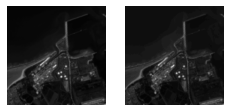

In [60]:
fig = plt.figure()
gs = plt.GridSpec(2, 3)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharex=ax1, sharey=ax1)
#ax3 = fig.add_subplot(gs[0, 2], sharex=ax1, sharey=ax1)
for aa in (ax1, ax2):
    aa.set_axis_off()

ax1.imshow(np.mean(BGR, axis=-1), cmap=plt.cm.gray)
ax2.imshow(BGR[:, :, 0], cmap=plt.cm.gray)
#ax3.imshow(matched, cmap=plt.cm.gray)


In [30]:
# Read the two image
B = BGR[:, :, -1].copy()
PAN = PAN.copy()

In [154]:
def wavelet_list():
    
    print("WAVELET TYPE:")
    for family in pywt.families():
        print("%s family: " % family + ', '.join(pywt.wavelist(family)))
    
    print("DECOMPOSITION MODES:")
    print(pywt.Modes.modes)
    
    print("FUSION METHOD:")
    print(['min', 'max', 'mean', 'band', 'pan'])
       
# wavelet_list()
wavelet = 'haar' # Wavelet Type
mode = 'symmetric' # Decomposition Mode
level = None # Number of Decomposition (None = All)
fusion = "mean" # Fusion method


# This function does the coefficient fusing according to the fusion method
def coef_fuse(B_coef, PAN_coef, fusion):

    if (fusion == 'mean'):
        coef = np.average((B_coef, PAN_coef), axis=0)
    elif (fusion == 'min'):
        coef = np.minimum(B_coef, PAN_coef)
    elif (fusion == 'max'):
        coef = np.maximum(B_coef, PAN_coef)
    elif (fusion == 'band'):
        coef = B_coef,
    elif (fusion == 'pan'):
        coef = PAN_coef
    else:
        raise ValueError('A very specific bad thing happened.')

    return tuple(coef)

# Decompose PAN
PAN_dec = pywt.wavedec2(data=PAN[:,:], mode=mode, wavelet=wavelet, level=level)

# Looping through Bands that needs to be panned
if len(BS.shape) == 2:
    BS = np.expand_dims(BS, axis=-1)
    
for Bi in range(BS.shape[-1]):
    # Wavelet Decomposition
    B_dec = pywt.wavedec2(data=B[:,:,Bi], mode=mode, wavelet=wavelet, level=level)
    
    # Dropping first empty decomposition
    B_dec = B_dec[:-1]
    
    # Fusing coefficient
    coef_fused = [coef_fuse(B_coef, PAN_coef, fusion) for B_coef, PAN_coef in zip(B_dec, PAN_dec)]
    
    # Inverse Wavelet Tramsformation
    img_fused = pywt.waverec2(coef_fused, wavelet)

# # Forth: normmalize values to be in uint8
# fusedImage = np.multiply(np.divide(img_fused - np.min(img_fused),(np.max(img_fused) - np.min(img_fused))),255)
# fusedImage = fusedImage.astype(np.uint8)

# # Fith: Show image
# cv2.imshow("win",fusedImage)

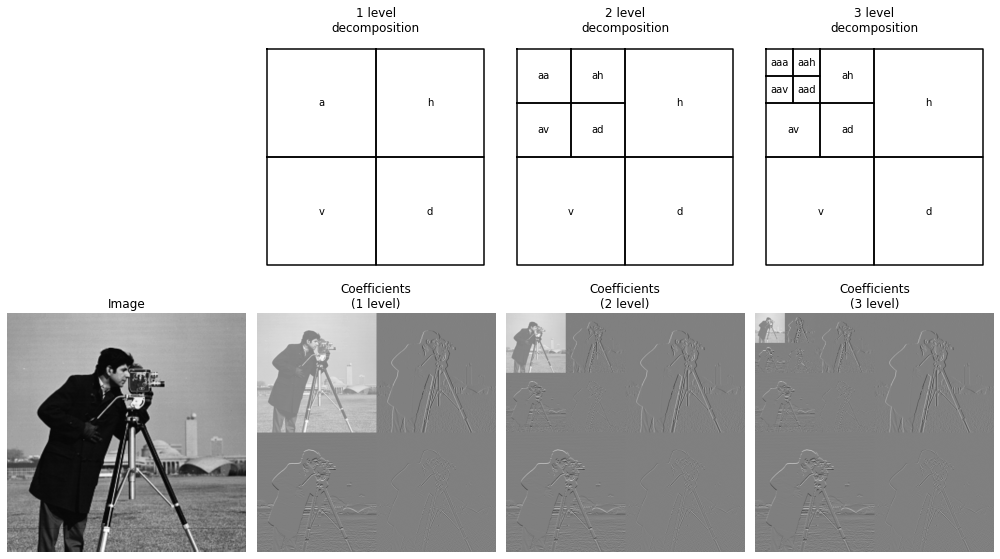

In [2]:
import numpy as np
import pywt
from matplotlib import pyplot as plt
from pywt._doc_utils import wavedec2_keys, draw_2d_wp_basis

x = pywt.data.camera().astype(np.float32)
shape = x.shape

max_lev = 3       # how many levels of decomposition to draw
label_levels = 3  # how many levels to explicitly label on the plots

fig, axes = plt.subplots(2, 4, figsize=[14, 8])
for level in range(0, max_lev + 1):
    if level == 0:
        # show the original image before decomposition
        axes[0, 0].set_axis_off()
        axes[1, 0].imshow(x, cmap=plt.cm.gray)
        axes[1, 0].set_title('Image')
        axes[1, 0].set_axis_off()
        continue

    # plot subband boundaries of a standard DWT basis
    draw_2d_wp_basis(shape, wavedec2_keys(level), ax=axes[0, level],
                     label_levels=label_levels)
    axes[0, level].set_title('{} level\ndecomposition'.format(level))

    # compute the 2D DWT
    c = pywt.wavedec2(x, 'haar', mode='periodization', level=level)
    # normalize each coefficient array independently for better visibility
    c[0] /= np.abs(c[0]).max()
    for detail_level in range(level):
        c[detail_level + 1] = [d/np.abs(d).max() for d in c[detail_level + 1]]
    # show the normalized coefficients
    arr, slices = pywt.coeffs_to_array(c)
    axes[1, level].imshow(arr, cmap=plt.cm.gray)
    axes[1, level].set_title('Coefficients\n({} level)'.format(level))
    axes[1, level].set_axis_off()

plt.tight_layout()
plt.show()